In [ ]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

In [ ]:
from src import save_jsonfile, read_jsonfile, create_train_dataset, create_test_dataset, plot_history
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

batch_size = 32

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# Lire le fichier CSV
df_train = pd.read_csv('data/processed/DL_train.csv')
df_test = pd.read_csv('data/processed/DL_test.csv')

# Convertir les chemins d'images et les étiquettes en tenseurs
X_train = df_train['image_path'].values
Y_train = df_train['category'].values
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

X_test = df_test['image_path'].values
y_test = df_test['category'].values

In [ ]:
train_dataset = create_train_dataset(X_train, y_train, batch_size)
val_dataset = create_train_dataset(X_val, y_val, batch_size)

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet') # Charger MobileNetV2 sans la couche de tête
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Ajouter une couche de pooling global
x = tf.keras.layers.Dense(1024, activation='relu')(x) # Ajouter une nouvelle couche dense
predictions = tf.keras.layers.Dense(6, activation='softmax')(x) # La nouvelle couche de sortie pour 6 classes
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Créer l'optimiseur avec le taux d'apprentissage souhaité
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compiler le modèle
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [7]:
ckpt_best_acc = ModelCheckpoint(
    filepath='models/MobileNetV2_ckpt_best_acc.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

ckpt_best_loss = ModelCheckpoint(
    filepath='models/MobileNetV2_ckpt_best_loss.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-9,
    verbose=1
)

In [8]:
# Entraîner le modèle
hist = model.fit(train_dataset,
                 epochs=100,
                 validation_data=val_dataset,
                 callbacks=[reduce_lr, ckpt_best_acc, ckpt_best_loss])

Epoch 1/100


2024-06-28 11:12:27.218811: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2024-06-28 11:12:31.085932: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


171/171 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.8837
Epoch 1: val_accuracy improved from -inf to 0.47141, saving model to models/MobileNetV2_ckpt_best_acc.keras

Epoch 1: val_loss improved from inf to 1.60868, saving model to models/MobileNetV2_ckpt_best_loss.keras
171/171 [==============================] - 127s 660ms/step - loss: 0.3479 - accuracy: 0.8837 - val_loss: 1.6087 - val_accuracy: 0.4714 - lr: 1.0000e-04
Epoch 2/100
171/171 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9529
Epoch 2: val_accuracy improved from 0.47141 to 0.47507, saving model to models/MobileNetV2_ckpt_best_acc.keras

Epoch 2: val_loss did not improve from 1.60868
171/171 [==============================] - 111s 647ms/step - loss: 0.1393 - accuracy: 0.9529 - val_loss: 1.9536 - val_accuracy: 0.4751 - lr: 1.0000e-04
Epoch 3/100
171/171 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9719
Epoch 3: val_accuracy improved from 0.47507 t

In [ ]:
hist.history['lr'] = np.array(hist.history['lr']).tolist()
save_jsonfile('models/MobileNetV2_history.json', hist.history, indent=4)

In [7]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

history = read_jsonfile('models/MobileNetV2_history.json')

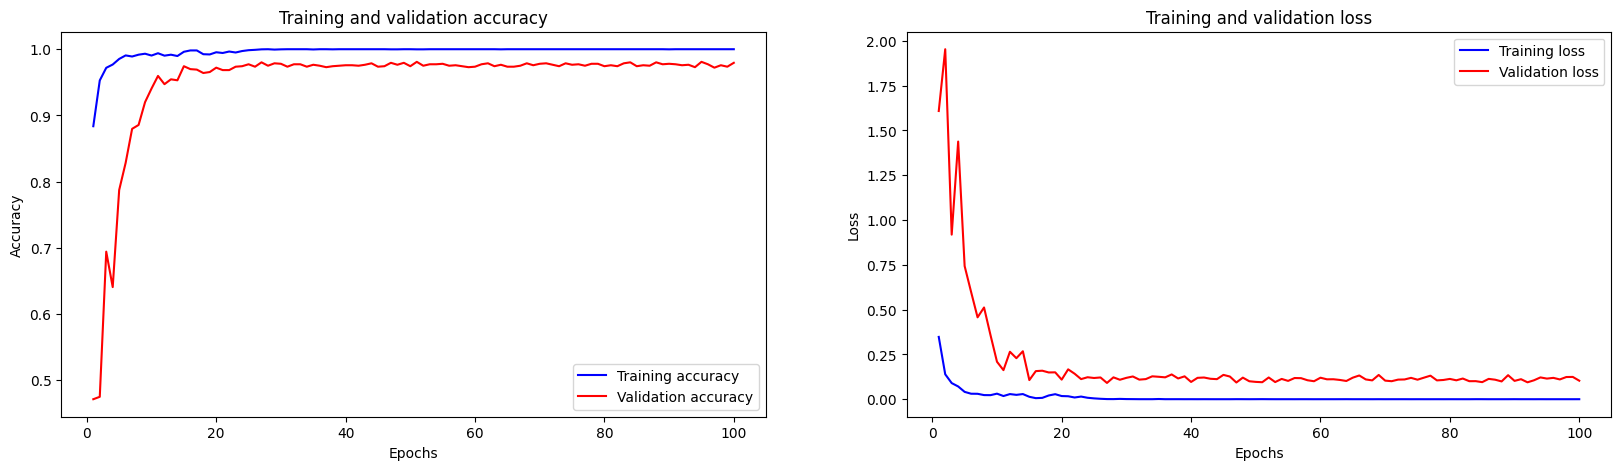

In [8]:
plot_history(history)

# Tests

In [17]:
from tensorflow.keras.models import load_model
from src import inference, create_test_dataset
from sklearn import metrics

model = load_model("models/MobileNetV2_ckpt_best_loss.keras")

df = pd.read_csv('data/processed/DL_test.csv')
X_test = df['image_path'].values
Y_test = df['category'].values
test_dataset = create_test_dataset(X_test, Y_test)

pred = model.predict(test_dataset)

54/54 [==============================] - 6s 105ms/step


In [18]:
print(metrics.classification_report(Y_test, pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       235
           1       0.97      0.96      0.97       243
           2       0.95      0.97      0.96       362
           3       0.99      1.00      1.00       305
           4       0.99      1.00      0.99       298
           5       0.99      0.97      0.98       261

    accuracy                           0.98      1704
   macro avg       0.98      0.98      0.98      1704
weighted avg       0.98      0.98      0.98      1704



# Simple Inference

In [19]:
pth = "./data/raw/data_02/images/img_0000049.jpg"
result = inference(model, pth)
result

1/1 [==============================] - 1s 560ms/step


'invoice'